# Prisoner's Dilemma Graph Visualization

This notebook demonstrates the updated Prisoner's Dilemma implementation where:
- Agents can see each other's choices and counters
- Strict JSON output format is enforced
- Sequential execution with 5 rounds per agent

In [1]:
from langchain_ollama.llms import OllamaLLM
from langgraph.graph import START, END, StateGraph, MessagesState
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from prompt import agent1_prompt, agent2_prompt
import json
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

## Model and Memory Setup

In [2]:
# Model setup
model = "mistral:latest"
llm = OllamaLLM(model=model)

# Memory setup
checkpointer = InMemorySaver()
config = {"configurable": {"thread_id": "1"}}

## State Classes

In [3]:
# Main subgraph state setup
class SubgraphState(TypedDict):
    agent_1_prompt: str
    agent_1_choice: list[str]
    agent_1_counter: int
    agent_2_prompt: str
    agent_2_choice: list[str]
    agent_2_counter: int

## Agent Nodes

In [ ]:
# subgraph nodes setup
def Agent1(state: SubgraphState):
    """
    This node takes in the current state of the subgraph and returns a new state with the agent's latest choice.
    The agent is given the other agent's latest choices as context.
    """
    opponent_last_choice = state['agent_2_choice'][-1] if state['agent_2_choice'] else None
    opponent_second_last_choice = state['agent_2_choice'][-2] if len(state['agent_2_choice']) >= 2 else None
    prompt_with_data = f"""{state['agent_1_prompt']}\n\n
    Your opponent's latest choices is : {opponent_last_choice}\n
    Your opponent's second last choices is : {opponent_second_last_choice}"""
    messages = llm.invoke(prompt_with_data)
    if isinstance(messages, str):
        response = json.loads(messages)
    return {"agent_1_choice": state["agent_1_choice"] + [response["agent_choice"]], "agent_1_counter": state["agent_1_counter"] + 1}

def Agent2(state: SubgraphState):
    """
    This node takes in the current state of the subgraph and returns a new state with the agent's latest choice.
    The agent is given the other agent's latest choices as context.
    """
    opponent_last_choice = state['agent_1_choice'][-1] if state['agent_1_choice'] else None
    opponent_second_last_choice = state['agent_1_choice'][-2] if len(state['agent_1_choice']) >= 2 else None
    prompt_with_data = f"""{state['agent_2_prompt']}\n\n
    Your opponent's latest choices is : {opponent_last_choice}\n
    Your opponent's second last choices is : {opponent_second_last_choice}"""
    messages = llm.invoke(prompt_with_data)
    if isinstance(messages, str):
        response = json.loads(messages)
    return {"agent_2_choice": state["agent_2_choice"] + [response["agent_choice"]], "agent_2_counter": state["agent_2_counter"] + 1}
    
def should_continue(state: SubgraphState) -> str:
    """Check if both agents have made 5 attempts"""
    if state["agent_1_counter"] < 5 or state["agent_2_counter"] < 5:
        return "loop"
    else:
        return "exit"

## Build the Subgraph

In [5]:
# subgraph setup
subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node("Agent1", Agent1)
subgraph_builder.add_node("Agent2", Agent2)
# adding parallel edges
subgraph_builder.add_edge(START, "Agent1")
subgraph_builder.add_edge(START, "Agent2")
subgraph_builder.add_conditional_edges("Agent1",
                                should_continue,
                                {
                                    "loop": "Agent1",  # If 'loop', repeat the loop
                                    "exit": END,       # If 'exit', terminate the workflow
                                })
subgraph_builder.add_conditional_edges("Agent2",
                                should_continue,
                                {
                                    "loop": "Agent2",  # If 'loop', repeat the loop
                                    "exit": END,       # If 'exit', terminate the workflow
                                })
subgraph = subgraph_builder.compile(checkpointer=checkpointer)

## Visualize the Graph

=== SUBGRAPH VISUALIZATION ===


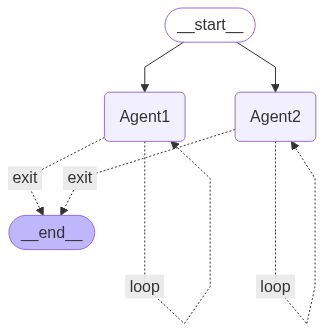

In [6]:
print("=== SUBGRAPH VISUALIZATION ===")
display(Image(subgraph.get_graph().draw_mermaid_png()))

## Main Graph Setup

The main graph contains the parent state and transform function that initializes and invokes the subgraph.

In [7]:
# graph state setup
class ParentState(TypedDict):
    agent_1_choice_parent: list[str]
    agent_2_choice_parent: list[str]
    payoff_agent_prompt : str
    payoffs: str
    
# graph node setup - UPDATED to include counter initialization
def get_subgraph_output(state: ParentState):
    response = subgraph.invoke({"agent_1_choice": state["agent_1_choice_parent"], 
    "agent_2_choice": state["agent_2_choice_parent"], "agent_1_prompt": agent1_prompt,
    "agent_2_prompt": agent2_prompt, "agent_1_counter": 1, "agent_2_counter": 1}, config=config) 
    return {"agent_1_choice_parent": response["agent_1_choice"], "agent_2_choice_parent": response["agent_2_choice"]}

def get_payoff(state: ParentState):
    empty_list_payoff_agent_1 = 0
    empty_list_payoff_agent_2 = 0

    for i in range(len(state["agent_1_choice_parent"])):
        for j in range(len(state["agent_2_choice_parent"])):
            if i == j:
                if state["agent_1_choice_parent"][i] == "COOPERATE" and state["agent_2_choice_parent"][j] == "COOPERATE":
                    empty_list_payoff_agent_1 += 3
                    empty_list_payoff_agent_2 += 3
                elif state["agent_1_choice_parent"][i] == "COOPERATE" and state["agent_2_choice_parent"][j] == "DEFECT":
                    empty_list_payoff_agent_1 += 0
                    empty_list_payoff_agent_2 += 5
                elif state["agent_1_choice_parent"][i] == "DEFECT" and state["agent_2_choice_parent"][j] == "COOPERATE":
                    empty_list_payoff_agent_1 += 5
                    empty_list_payoff_agent_2 += 0
                elif state["agent_1_choice_parent"][i] == "DEFECT" and state["agent_2_choice_parent"][j] == "DEFECT":
                    empty_list_payoff_agent_1 += 1
                    empty_list_payoff_agent_2 += 1
            else:
                continue
    return {"payoffs": {"agent_1_payoff": empty_list_payoff_agent_1, "agent_2_payoff": empty_list_payoff_agent_2}}

In [8]:
graph_builder = StateGraph(ParentState)
graph_builder.add_node("get_subgraph_output", get_subgraph_output)
graph_builder.add_node("get_payoff", get_payoff)
graph_builder.add_edge(START, "get_subgraph_output")
graph_builder.add_edge("get_subgraph_output", "get_payoff")
graph_builder.add_edge("get_payoff", END)
graph = graph_builder.compile(checkpointer=checkpointer)

=== MAIN GRAPH VISUAL ===


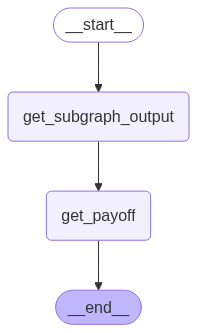

In [9]:
print("=== MAIN GRAPH VISUAL ===")
display(Image(graph.get_graph().draw_mermaid_png()))

## Run a Game Session

In [10]:
def run_game():
    for event in graph.stream({ 
        "agent_1_choice_parent": [], 
        "agent_2_choice_parent": [],
    }, subgraphs=True, config=config):
        print(event)

run_game()

((), {'get_subgraph_output': {'agent_1_choice_parent': ['COOPERATE', 'COOPERATE', 'DEFECT', 'DEFECT', 'COOPERATE'], 'agent_2_choice_parent': ['COOPERATE', 'DEFECT', 'DEFECT', 'COOPERATE', 'COOPERATE']}})
((), {'get_payoff': {'payoffs': {'agent_1_payoff': 12, 'agent_2_payoff': 12}}})
